In [1]:
import torch
import pandas as pd
from torch.optim import AdamW
from transformers import get_scheduler
import torch.nn as nn
from transformers import T5ForConditionalGeneration, Trainer, TrainingArguments
from src.load_dataloader import initial_dataloader
from src.load_dataloader import initial_dataloader_cv
from src.evaluation import initial_LSTM
from src.evaluation import evaluate
from src.evaluation import evaluate_process
from src.evaluation import predict
from src.load_config import load_config
from src.evaluation import show_sentence
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

max_length = 128

c:\Users\Gus Li\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data_preprocess/datasets_combine.csv')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
df


,sentence,label
0,"PETRUCHIO:You are very sensible, and yet you m...",1
1,"Say to me, when sawest thou the Prince Florize...",1
2,KING RICHARD III:I cry thee mercy:There is my ...,1
3,Everyday Hüseyin Burak Tuzer sees breathtaking...,0
4,"BIANCA:Good sister, wrong me not, nor wrong yo...",1
...,...,...
15769,"ISABELLA:My brother did love Juliet,And you te...",1
15770,"Now will I in, to take some privy order,To dra...",1
15771,"Provost:I would do more than that, if more wer...",1
15772,New law requires immigrants to carry alien reg...,0


In [5]:
15774/2

7887.0

In [6]:

from transformers import T5Tokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import random
tokenizer=T5Tokenizer.from_pretrained('t5-small')


class T5Dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
            return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        return {
            'input_ids': torch.tensor(item['input_ids'], dtype=torch.long).squeeze(0),
            'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long).squeeze(0),
            'labels': torch.tensor(item['labels'], dtype=torch.long).squeeze(0)
    }



def mask_tokens(inputs, tokenizer, mlm_probability=0.5):
    """
    Prepare masked tokens inputs/labels for T5: 15% random spans
    """
    # Create a mask array
    labels = inputs.clone()
    masked_indices = torch.bernoulli(torch.full(labels.shape, mlm_probability)).bool()
    labels[~masked_indices] = -100  # Only compute loss on masked tokens

    # Replace masked input tokens with a sentinel token (for T5)
    sentinel_token_id = tokenizer.convert_tokens_to_ids('<extra_id_0>')
    inputs[masked_indices] = sentinel_token_id

    return inputs, labels

def get_random_sentence_from_different_label(current_label, grouped_sentences):
    possible_labels = list(grouped_sentences.keys())
    possible_labels.remove(current_label)  # Remove current label
    random_label = random.choice(possible_labels)  # Choose a different label
    return random.choice(grouped_sentences[random_label])

def tokenize_and_mask(batch, tokenizer, max_length):
    tokenized_input = tokenizer(batch['input_text'], padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
    masked_input, labels = mask_tokens(tokenized_input['input_ids'], tokenizer)
    return {
            'input_ids': masked_input,
            'labels': labels,
            'attention_mask': tokenized_input['attention_mask']
        }

def initial_dataloader(df, tokenizer, max_length):
    # Assuming your columns are named 'sentence' and 'label'
    df['input_text'] = df['sentence']
    
    # create target text that is a random sentence different label of input text 
    grouped_sentences = df.groupby('label')['input_text'].apply(list).to_dict()
    df['target_text'] = df.apply(lambda row: get_random_sentence_from_different_label(row['label'], grouped_sentences), axis=1)
    # invert the label
    df['transform_style'] = df['label'].apply(lambda x: 1 if x == 0 else 0)

    # Split into training and validation sets

    train_df, val_df = train_test_split(df, test_size=0.1)
    train_df, test_df = train_test_split(train_df, test_size=0.01)





    
    return train_df, val_df, test_df


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [16]:
train_df

,sentence,label,input_text,target_text,transform_style
10934,The 35-year-old denies one charge of pervertin...,0,The 35-year-old denies one charge of pervertin...,GLOUCESTER:Your beauty was the cause of that e...,1
15658,GRUMIO:There,1,GRUMIO:There,"Thousands watch activities of Korean woman, du...",0
13357,LUCIO:She it is,1,LUCIO:She it is,The music is played through whistle openings o...,0
4927,Here comes a gentleman that haply knows more,1,Here comes a gentleman that haply knows more,Russian fishermen net a huge Steller sea lion ...,0
6203,"DUKE VINCENTIO:Why, you are nothing then: neit...",1,"DUKE VINCENTIO:Why, you are nothing then: neit...","Major search was launched, with 100 locals joi...",0
...,...,...,...,...,...
794,"PAULINA:Had our prince,Jewel of children, seen...",1,"PAULINA:Had our prince,Jewel of children, seen...",The group has 600 paid youth apprenticeship pl...,0
15178,"Title of the new western-themed episode is ""Ha...",0,"Title of the new western-themed episode is ""Ha...","First Murderer:So do not I: go, coward as thou...",1
12178,"Cupp: At press conference, Hillary Clinton ins...",0,"Cupp: At press conference, Hillary Clinton ins...",The benefit thereof is always grantedTo those ...,1
9644,GLOUCESTER:What! threat you me with telling of...,1,GLOUCESTER:What! threat you me with telling of...,"Oxford, Manchester, Cardiff and Sheffield amon...",0


In [7]:
train_df, val_df, test_df = initial_dataloader(df, tokenizer, max_length)

In [8]:
# model1 prepare. Model one is transfer CNN to Sheakspear

model1_train_data= train_df[train_df['transform_style']==1]
model1_validataion_data= val_df[val_df['transform_style']==1]

model1_train_data = model1_train_data.apply(lambda x: tokenize_and_mask(x, tokenizer, max_length), axis=1)
model1_validataion_data = model1_validataion_data.apply(lambda x: tokenize_and_mask(x, tokenizer, max_length), axis=1)

model1_train_data = T5Dataset(model1_train_data)
model1_validataion_data = T5Dataset(model1_validataion_data)

model1= T5ForConditionalGeneration.from_pretrained('t5-small').to(device)
training_args = TrainingArguments(
    output_dir='./results/prompt_model1',          # output directory for model checkpoints
    num_train_epochs=5,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.001,               # strength of weight decay
    learning_rate=1e-5,
    logging_dir='./logs/rompt_model1',            # directory for storing logs
    logging_steps=500,
    do_train=True,                   # whether to run training
    do_eval=True,                    # whether to run eval on the dev set
    evaluation_strategy="steps",     # evaluation strategy to adopt during training
    eval_steps=500,                  # evaluation step
    save_steps=500,                  # save checkpoint every 500 steps
    save_total_limit=1,              # only keep the most recent checkpoint
)

# Initialize Trainer
trainer = Trainer(
    model=model1,
    args=training_args,
    train_dataset=model1_train_data,  # your training dataset
    eval_dataset=model1_validataion_data,   # your evaluation dataset
    # You can also include a compute_metrics function to calculate metrics during evaluation
)

# Train the model
trainer.train()

# Save the model
trainer.save_model('./save_model/prompt_model1')

# Evaluate the model
trainer.evaluate()


  0%|          | 0/2195 [00:00<?, ?it/s]C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(item['input_ids'], dtype=torch.long).squeeze(0),
C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long).squeeze(0),
C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 

{'loss': 8.9789, 'learning_rate': 1e-05, 'epoch': 1.14}


                                                  
 23%|██▎       | 500/2195 [01:26<05:03,  5.59it/s]

{'eval_loss': 1.5126492977142334, 'eval_runtime': 2.734, 'eval_samples_per_second': 292.975, 'eval_steps_per_second': 18.654, 'epoch': 1.14}


C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(item['input_ids'], dtype=torch.long).squeeze(0),
C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long).squeeze(0),
C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(item['labels'], 

{'loss': 1.4586, 'learning_rate': 7.050147492625369e-06, 'epoch': 2.28}


                                                   
 46%|████▌     | 1000/2195 [02:49<02:48,  7.08it/s]

{'eval_loss': 1.10295569896698, 'eval_runtime': 2.3503, 'eval_samples_per_second': 340.811, 'eval_steps_per_second': 21.7, 'epoch': 2.28}


C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(item['input_ids'], dtype=torch.long).squeeze(0),
C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long).squeeze(0),
C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(item['labels'], 

{'loss': 1.1659, 'learning_rate': 4.100294985250738e-06, 'epoch': 3.42}


                                                   
 68%|██████▊   | 1500/2195 [04:04<01:35,  7.27it/s]

{'eval_loss': 1.0342704057693481, 'eval_runtime': 2.3501, 'eval_samples_per_second': 340.832, 'eval_steps_per_second': 21.701, 'epoch': 3.42}


C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(item['input_ids'], dtype=torch.long).squeeze(0),
C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long).squeeze(0),
C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(item['labels'], 

{'loss': 1.0949, 'learning_rate': 1.1504424778761064e-06, 'epoch': 4.56}


                                                   
 91%|█████████ | 2000/2195 [05:24<00:28,  6.84it/s]

{'eval_loss': 1.0023003816604614, 'eval_runtime': 2.4451, 'eval_samples_per_second': 327.589, 'eval_steps_per_second': 20.858, 'epoch': 4.56}


C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(item['input_ids'], dtype=torch.long).squeeze(0),
C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long).squeeze(0),
C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(item['labels'], 

{'train_runtime': 354.8243, 'train_samples_per_second': 98.809, 'train_steps_per_second': 6.186, 'train_loss': 2.989131543413653, 'epoch': 5.0}


100%|██████████| 51/51 [00:02<00:00, 21.73it/s]


{'eval_loss': 1.0003931522369385,
 'eval_runtime': 2.3521,
 'eval_samples_per_second': 340.542,
 'eval_steps_per_second': 21.682,
 'epoch': 5.0}

In [9]:
# load model
model1 = T5ForConditionalGeneration.from_pretrained('./save_model/prompt_model1').to(device)

In [10]:
# model2 prepare. Model two is transfer Sheakspear to CNN
model2_train_data= train_df[train_df['transform_style']==0]
model2_validataion_data= val_df[val_df['transform_style']==0]
model2_train_data
model2_validataion_data

model2_train_data = model2_train_data.apply(lambda x: tokenize_and_mask(x, tokenizer, max_length), axis=1)
model2_validataion_data = model2_validataion_data.apply(lambda x: tokenize_and_mask(x, tokenizer, max_length), axis=1)

model2_train_data = T5Dataset(model2_train_data)
model2_validataion_data = T5Dataset(model2_validataion_data)

model2= T5ForConditionalGeneration.from_pretrained('t5-small').to(device)
training_args2 = TrainingArguments(
    output_dir='./results/prompt_model2',          # output directory for model checkpoints
    num_train_epochs=5,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.001,               # strength of weight decay
    learning_rate=1e-5,
    logging_dir='./logs/rompt_model2',            # directory for storing logs
    logging_steps=500,
    do_train=True,                   # whether to run training
    do_eval=True,                    # whether to run eval on the dev set
    evaluation_strategy="steps",     # evaluation strategy to adopt during training
    eval_steps=500,                  # evaluation step
    save_steps=500,                  # save checkpoint every 500 steps
    save_total_limit=1,              # only keep the most recent checkpoint
)

# Initialize Trainer
trainer2 = Trainer(
    model=model2,
    args=training_args2,
    train_dataset=model2_train_data,  # your training dataset
    eval_dataset=model2_validataion_data,   # your evaluation dataset
    # You can also include a compute_metrics function to calculate metrics during evaluation
)

# Train the model
trainer2.train()

# Save the model
trainer2.save_model('./save_model/prompt_model2')

# Evaluate the model
trainer2.evaluate()


  0%|          | 0/2205 [00:00<?, ?it/s]C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(item['input_ids'], dtype=torch.long).squeeze(0),
C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long).squeeze(0),
C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 

{'loss': 8.047, 'learning_rate': 1e-05, 'epoch': 1.13}


                                                  
 23%|██▎       | 500/2205 [01:31<05:14,  5.42it/s]

{'eval_loss': 2.648172378540039, 'eval_runtime': 2.5064, 'eval_samples_per_second': 310.011, 'eval_steps_per_second': 19.55, 'epoch': 1.13}


C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(item['input_ids'], dtype=torch.long).squeeze(0),
C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long).squeeze(0),
C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(item['labels'], 

{'loss': 2.687, 'learning_rate': 7.067448680351907e-06, 'epoch': 2.27}


                                                   
 45%|████▌     | 1000/2205 [02:59<03:43,  5.40it/s]

{'eval_loss': 2.1965103149414062, 'eval_runtime': 2.516, 'eval_samples_per_second': 308.819, 'eval_steps_per_second': 19.475, 'epoch': 2.27}


C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(item['input_ids'], dtype=torch.long).squeeze(0),
C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long).squeeze(0),
C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(item['labels'], 

{'loss': 2.3265, 'learning_rate': 4.134897360703813e-06, 'epoch': 3.4}


                                                   
 68%|██████▊   | 1500/2205 [04:15<02:05,  5.60it/s]

{'eval_loss': 2.0948431491851807, 'eval_runtime': 2.534, 'eval_samples_per_second': 306.63, 'eval_steps_per_second': 19.337, 'epoch': 3.4}


C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(item['input_ids'], dtype=torch.long).squeeze(0),
C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long).squeeze(0),
C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(item['labels'], 

{'loss': 2.2292, 'learning_rate': 1.2023460410557186e-06, 'epoch': 4.54}


                                                   
 91%|█████████ | 2000/2205 [05:42<00:28,  7.10it/s]

{'eval_loss': 2.053736686706543, 'eval_runtime': 2.3029, 'eval_samples_per_second': 337.405, 'eval_steps_per_second': 21.278, 'epoch': 4.54}


C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(item['input_ids'], dtype=torch.long).squeeze(0),
C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(item['attention_mask'], dtype=torch.long).squeeze(0),
C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(item['labels'], 

{'train_runtime': 374.0515, 'train_samples_per_second': 94.131, 'train_steps_per_second': 5.895, 'train_loss': 3.6733348336079223, 'epoch': 5.0}


C:\Users\Gus Li\AppData\Local\Temp\ipykernel_43988\2075914723.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(item['labels'], dtype=torch.long).squeeze(0)
100%|██████████| 49/49 [00:02<00:00, 21.62it/s]


{'eval_loss': 2.049675941467285,
 'eval_runtime': 2.2726,
 'eval_samples_per_second': 341.902,
 'eval_steps_per_second': 21.561,
 'epoch': 5.0}

In [ ]:
# load the saved model
model2= T5ForConditionalGeneration.from_pretrained('./save_model/prompt_model2').to(device)

In [ ]:
model2

In [ ]:
df

In [11]:
# show sentence
for i in range(10):
    if test_df.iloc[i]['transform_style'] == 1:
        show_sentence(i, test_df, tokenizer, model1, device, max_length)
    else:
        show_sentence(i, test_df, tokenizer, model2, device, max_length)

Original Sentence: Had an 11-hour operation in which a titanium rod was fitted to her spine
Target Sentence style: TYBALT:I am for you
Generated Sentence: 
Original Sentence: Kennedy family has never confirmed or denied the story
Target Sentence style: 'QUEEN ELIZABETH:Thus have you breathed your curse against yourself
Generated Sentence: Kennedy family has never confirmed or denied the story to the written style of 'QUEEN ELIZABETH:Thus have you breathed your curse against yourself'
Original Sentence: MONTAGUE:Who set this ancient quarrel new abroach?Speak, nephew, were you by when it began?BENVOLIO:Here were the servants of your adversary,And yours, close fighting ere I did approach:I drew to part them: in the instant cameThe fiery Tybalt, with his sword prepared,Which, as he breathed defiance to my ears,He swung about his head and cut the winds,Who nothing hurt withal hiss'd him in scorn:While we were interchanging thrusts and blows,Came more and more and fought on part and part,Til

In [12]:
def evaluate_model(df, model1, model2, model_eval, tokenizer, device, max_length):
    model1.eval()
    model2.eval()
    predictions, labels = [], []

    with torch.no_grad():
        for i in range(len(df)):
            source_sentence = df.iloc[i]['input_text']
            transform_style = df.iloc[i]['transform_style']

            # Choose the model based on the transform_style
            model = model1 if transform_style == 1 else model2

            #input_text = f"transform the written style of {source_sentence}"
            input_text = source_sentence
            input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
            outputs = model.generate(input_ids=input_ids, max_length=max_length, num_beams=10, early_stopping=True)
            transformed_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True)
            
            prediction = predict(transformed_sentence, model_eval, tokenizer, device, max_length)
            # Apply softmax and use argmax to get the label
            prediction = torch.argmax(torch.nn.functional.softmax(prediction, dim=0), dim=0).item()

            predictions.append(prediction)
            labels.append(transform_style)

    return predictions, labels

def evaluate_process(test_df, model1, model2, tokenizer, device, max_length):
    model_eval = initial_LSTM(tokenizer, device)
    predictions, labels = evaluate_model(test_df, model1, model2, model_eval, tokenizer, device, max_length)
    return predictions, labels


In [13]:
def evaluate_process(test_df, model1, model2, tokenizer, device, max_length):
    model_eval = initial_LSTM(tokenizer, device)
    predictions, labels = evaluate_model(test_df, model1, model2, model_eval, tokenizer, device, max_length)
    return predictions, labels

In [14]:
predictions, labels = evaluate_process(test_df, model1,model2,tokenizer, device, max_length)

tensor([10118,     3,     9,   850,    18,  5842,  2986,    16,    84,     3,
            9, 28663,  6102,    47,  9695,    12,   160, 14732,     1,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],

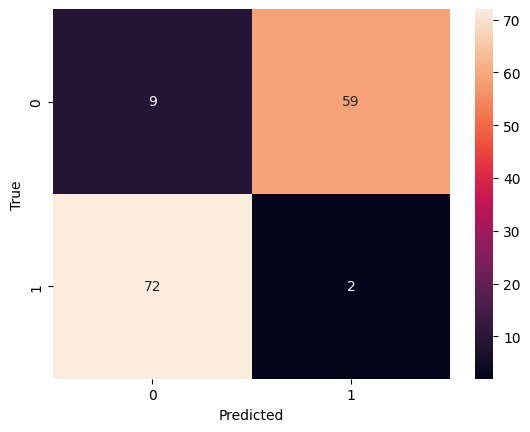

In [17]:
cm = confusion_matrix(labels, predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

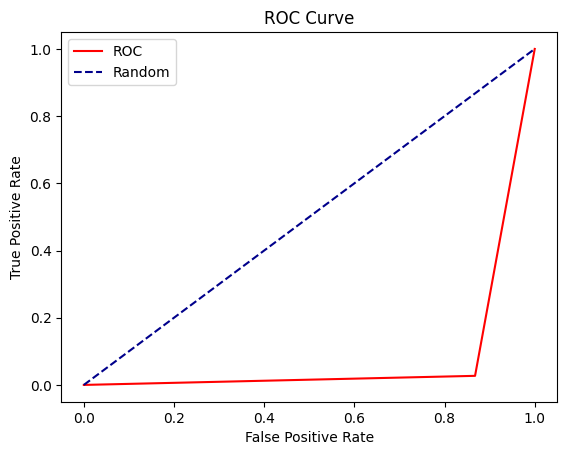

In [15]:
predict = predictions
True_label = labels
fpr, tpr, thresholds = roc_curve(True_label, predict)
auc = roc_auc_score(True_label, predict)
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()